In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [4]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

load *SessionPulses.Events.mat failed


In [5]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_2

In [6]:
donormalize=False
X_restacked_df_d=nmf_res_d[(donormalize,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(donormalize,1,True)]['W_df_peaks_only_d']

key=(0,1)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
X = X_peaks
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

<AxesSubplot:xlabel='trial'>

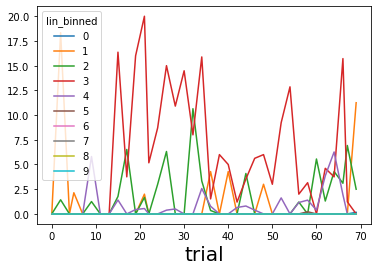

In [126]:
X_restacked_df_d[(0,1)].loc[465].T.plot()

# pre post sleep ripple cofiring 

In [10]:
ripples = mat_to_return['ripples']
ripple_events = ripples

cell_metrics=mat_to_return.cell_metrics
mergepoints = mat_to_return.mergepoints

cell_type_mask=mat_to_return['cell_type_mask']

In [11]:
%%time
spike_times = cell_metrics.spikes.times
ripple_events_timestamps = ripple_events.timestamps


participation_mask_l_d_epochs=[]
ripple_time_ints_l_d_epochs=[]
for selected_interval in mergepoints.timestamps:
# selected_interval = mergepoints.timestamps[0]
    spike_times_in_ripple_l_d,mask_l_d, ripple_time_ints_l_d = {},{},{}
    for k,win in zip(['ripple_only','extended'],[None,[-0.2,0.1]]):
        spike_times_in_ripple_l_d[k], mask_l_d[k], ripple_time_ints_l_d[k] = prep.get_spike_times_in_ripple_l(spike_times,ripple_events_timestamps,selected_interval,ripple_window_extension=win,cell_type_mask=cell_type_mask)
        mask_l_d[k] = np.array(mask_l_d[k])


    rank_l_d,participation_mask_l_d = {},{}
    for k,stirl in spike_times_in_ripple_l_d.items():
        rank_l_d[k],participation_mask_l_d[k] = prep.get_first_spike_rank_all_ripples(stirl)
    participation_mask_l_d_epochs.append(participation_mask_l_d)
    ripple_time_ints_l_d_epochs.append(ripple_time_ints_l_d)

CPU times: user 1min 12s, sys: 3.04 s, total: 1min 15s
Wall time: 1min 15s


In [12]:
from scipy.spatial.distance import dice,pdist,squareform

In [13]:
sim_df_l = []
for participation_mask_l_d in participation_mask_l_d_epochs:
    dist = pdist(participation_mask_l_d['ripple_only'].T,metric=dice)
    sim = 1 - squareform(dist)
    sim_df = pd.DataFrame(sim,index=cell_cols_d['pyr'].astype(int),columns=cell_cols_d['pyr'].astype(int))
    sim_df_l.append(sim_df)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/spatial/distance.py:1424: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/spatial/distance.py:1424: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


In [131]:
uid=475
for ii in range(3):
    print(sim_df_l[ii].loc[uid].sort_values(ascending=False).iloc[1:])

454    0.290909
476    0.136986
312    0.123077
274    0.114286
437    0.111111
         ...   
248    0.000000
250    0.000000
251    0.000000
253    0.000000
358    0.000000
Name: 475, Length: 421, dtype: float64
454    0.600000
338    0.461538
436    0.434783
476    0.400000
411    0.375000
         ...   
136    0.000000
315    0.000000
134    0.000000
132    0.000000
1      0.000000
Name: 475, Length: 421, dtype: float64
454    0.553571
411    0.468085
3      0.329897
436    0.306011
338    0.256228
         ...   
302    0.000000
300    0.000000
296    0.000000
294    0.000000
1      0.000000
Name: 475, Length: 421, dtype: float64


In [14]:
cols=pd.MultiIndex.from_product([['pre','beh','post'],sim_df_l[0].columns])
sim_df_l_df = pd.concat(sim_df_l,axis=1)
sim_df_l_df.columns=cols

In [143]:
sim_df_l_df.loc[uid].unstack().T.corr()

,beh,post,pre
beh,1.000000,0.605470,0.420619
post,0.605470,1.000000,0.755949
pre,0.420619,0.755949,1.000000


In [15]:
sim_df_l_df_corr=sim_df_l_df.corr()

In [152]:
import itertools
sim_compare = {}
for i,j in itertools.combinations(['pre','beh','post'],2):
    compare = pd.Series(np.diag(sim_df_l_df_corr.loc[i,j]),index=sim_df_l_df.index)
    sim_compare[(i,j)]=compare

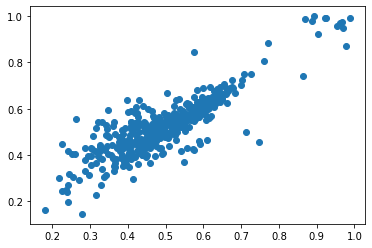

In [156]:
plt.scatter(sim_compare['pre','beh'],sim_compare['beh','post'])

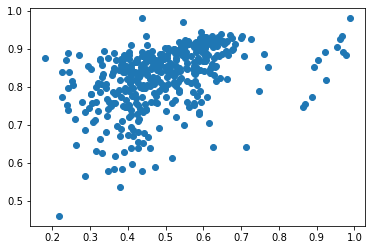

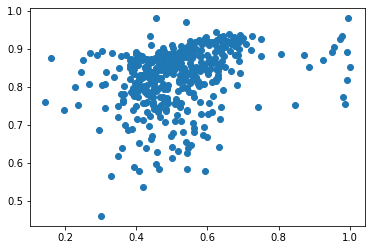

In [158]:
plt.scatter(sim_compare['pre','beh'],sim_compare['pre','post'])
plt.figure()
plt.scatter(sim_compare['beh','post'],sim_compare['pre','post'])

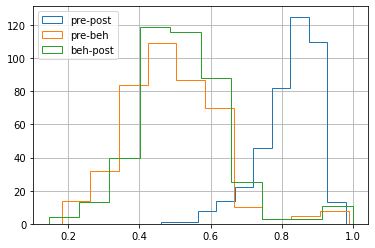

In [167]:
sim_compare['pre','post'].hist(histtype='step')
sim_compare['pre','beh'].hist(histtype='step')
sim_compare['beh','post'].hist(histtype='step')
plt.legend(['pre-post','pre-beh','beh-post'])

In [121]:
X.loc[459].plot()

trial,0.0,2.0,4.0,5.0,7.0,9.0,11.0,13.0,15.0,17.0,...,52.0,54.0,56.0,58.0,60.0,62.0,64.0,66.0,67.0,69.0
lin_binned,,,,,,,,,,,,,,,,,,,,,
1,1.764706,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.000000
7,1.538462,5.789474,7.5,10.434782,1.153846,1.153846,0.0,0.0,1.0,1.071429,...,2.727273,15.714285,20.526315,10.824742,16.875,28.636363,16.25,24.166666,10.909091,14.210526


In [16]:
pre_dist = pdist(participation_mask_l_d_epochs[0]['ripple_only'].T,metric=dice)

In [17]:
pre_sim_corr = np.corrcoef(participation_mask_l_d_epochs[0]['ripple_only'].T)

In [18]:
pre_sim_corr_df=pd.DataFrame(pre_sim_corr,index=cell_cols_d['pyr'].astype(int),columns=cell_cols_d['pyr'].astype(int))


In [71]:
cell_cols_d['pyr']

array([  1.,   2.,   3.,  27.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  43.,  44.,  45.,  46.,  48.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  62.,  67.,  68.,
        81.,  82.,  83.,  84.,  85.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 139.,
       140., 143., 144., 145., 146., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       200., 201., 202., 203., 204., 205., 206., 20

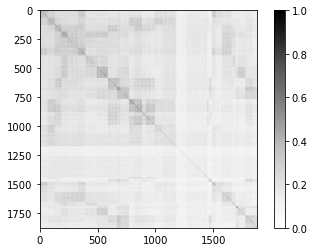

In [79]:
%matplotlib inline
sim = 1-squareform(pre_dist)
import trial_correlates as tc
sim_sorted,inds=tc.cluster_corr(sim)
plt.imshow(sim_sorted)
plt.colorbar()

In [19]:
pre_dist_df=pd.DataFrame(squareform(pre_dist),index=cell_cols_d['pyr'].astype(int),columns=cell_cols_d['pyr'].astype(int))


In [20]:
pre_sim_df = 1-pre_dist_df

In [89]:
pre_sim_sorted,inds=tc.cluster_corr(pre_sim_df.values)

<AxesSubplot:>

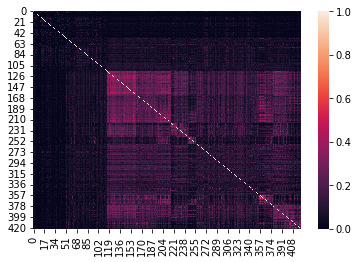

In [90]:
sns.heatmap(pre_sim_sorted)

In [100]:
pre_sim_corr_df.loc[459].sort_values(ascending=False)

459    1.000000
291    0.270443
288    0.255197
374    0.253905
299    0.231406
         ...   
202   -0.080975
57    -0.086153
379   -0.089001
385   -0.102296
193   -0.102309
Name: 459, Length: 422, dtype: float64

In [96]:
pre_sim_df.loc[459].sort_values(ascending=False)

459    1.000000
291    0.360485
374    0.345924
288    0.330749
299    0.326951
         ...   
264    0.000000
55     0.000000
441    0.000000
277    0.000000
302    0.000000
Name: 459, Length: 422, dtype: float64

(array([3.6613e+04, 2.5278e+04, 1.4402e+04, 7.5490e+03, 3.3950e+03,
        1.1810e+03, 3.1600e+02, 7.9000e+01, 1.1000e+01, 7.0000e+00]),
 array([0.        , 0.06348123, 0.12696246, 0.19044369, 0.25392491,
        0.31740614, 0.38088737, 0.4443686 , 0.50784983, 0.57133106,
        0.63481229]),
 <BarContainer object of 10 artists>)

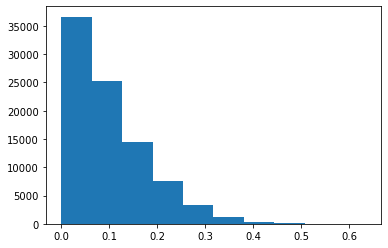

In [108]:
plt.hist(1-pre_dist)

# rate map 

In [22]:
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)

In [12]:
spk_beh_df.groupby('trial_type')

In [23]:
from scipy.ndimage import gaussian_filter1d
def ratemap_from_spk_beh_df_onetrialtype(spk_beh_df,cell_cols,speed_thresh=1,nbins=100,smth_in_bin=5):
    '''
    fr_map: nneurons x nposbins
    '''
    spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],nbins,retbins=True,labels=False)
    speed_ma = spk_beh_df['speed'] > speed_thresh
    spk_beh_df_ma = spk_beh_df.loc[speed_ma]
    gpb = spk_beh_df_ma.groupby(['lin_binned'])
    occu = gpb['lin'].count()
#     occu_smth = occu.rolling(nbins,center=True,win_type='gaussian',min_periods=1).mean(std=smth_in_bin)
    occu_smth = gaussian_filter1d(occu.values.astype(float),sigma=smth_in_bin)
    count = gpb[cell_cols].sum()
#     count_smth = count.rolling(nbins,center=True,win_type='gaussian',min_periods=1).mean(std=smth_in_bin)
    count_smth = gaussian_filter1d(count.values.astype(float),sigma=smth_in_bin,axis=0) # float is crucial!
    
#     fr = count_smth.values / occu_smth.values[:,None]
    fr = count_smth / occu_smth[:,None]
    dt = np.median(np.diff(spk_beh_df.index))
    fr = fr / dt
    fr_map = pd.DataFrame(fr,index=count.index,columns=count.columns).T
    return fr_map,count_smth.T,occu_smth,bins

def ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1,nbins=100,smth_in_bin=5):
    if 'trial_type' not in spk_beh_df.columns:
        _,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
    gpb = spk_beh_df.groupby('trial_type')
    
    fr_map_d,count_smth_d,occu_smth_d,bins_d = {},{},{},{}
    for k,val in gpb:
        fr_map_d[k],count_smth_d[k],occu_smth_d[k],bins_d[k]=ratemap_from_spk_beh_df_onetrialtype(val,cell_cols,speed_thresh=speed_thresh,nbins=nbins,smth_in_bin=smth_in_bin)
    return fr_map_d,count_smth_d,occu_smth_d,bins_d
        

In [24]:
import place_field_analysis as pf

In [25]:
cell_cols = cell_cols_d['pyr']
fr_map_d,count_d,occu_d,bins_d = ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=5,nbins=100,smth_in_bin=2.5)
spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],100,retbins=True,labels=False)


# key=(0,0)
fr_map_peaks_d = {}
field_res_d = {}
for key in fr_map_d.keys():
#     fr_map_peaks_d[key]=fr_map_d[key].apply(lambda x:scipy.signal.find_peaks(x,height=1)[0],axis=1)
    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
#     dt=0.033
#     pvals_df = test_frmap_sig(fr_map,count,occu,dt)
#     isfield=(pvals_df < 0.01) & (count > 3) & (fr_map > 1) 
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu)
    

In [97]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [26]:
key = (0,1)
distthresh=5
uid=162
fr_map_peaks_tested_df=field_res_d[key]['fr_map_peaks_tested_df']
selected_d,dist_sorted_d = pf.find_closest_neurons(fr_map_peaks_tested_df,uid=uid,posbin_l=None,nselected=None,distthresh=distthresh)


In [50]:
# pop up, no other field, uid162, trialtype1

In [123]:
fr_map_peaks_tested_df.loc[162]

0    56.0
1     NaN
2     NaN
Name: 162, dtype: float64

In [27]:
import plot_raster as pr
reload(pr)

<module 'plot_raster' from '/mnt/home/szheng/projects/util_code/plot_raster.py'>

In [28]:
reload(pf)
ep=pf.get_trial_ep(spk_beh_df,trial_type=(0,1),pos_range=(110,135),pos_key='lin',trial_index_range=None,trial_index_within_trialtype_range=(13,14))





In [29]:
import scipy.interpolate
from scipy.interpolate import interp1d

lin_func = interp1d(beh_df.index,spk_beh_df['lin'])

In [30]:
%matplotlib inline
uid_l = list(selected_d.values())[0]
uid_l.insert(0,uid)
reload(pr)
# ep = (spk_beh_df.loc[ma].index[0],spk_beh_df.loc[ma].index[-1])
# fig,ax,_=pr.population_raster(spike_trains,uid_l=uid_l,ep=ep,pos_func=lin_func)

<module 'plot_raster' from '/mnt/home/szheng/projects/util_code/plot_raster.py'>

/mnt/home/szheng/projects/util_code/plot_raster.py:404: UserWarning: FixedFormatter should only be used together with FixedLocator
  aa.set_xticklabels(np.round(pos_func(aa.get_xticks()),1))


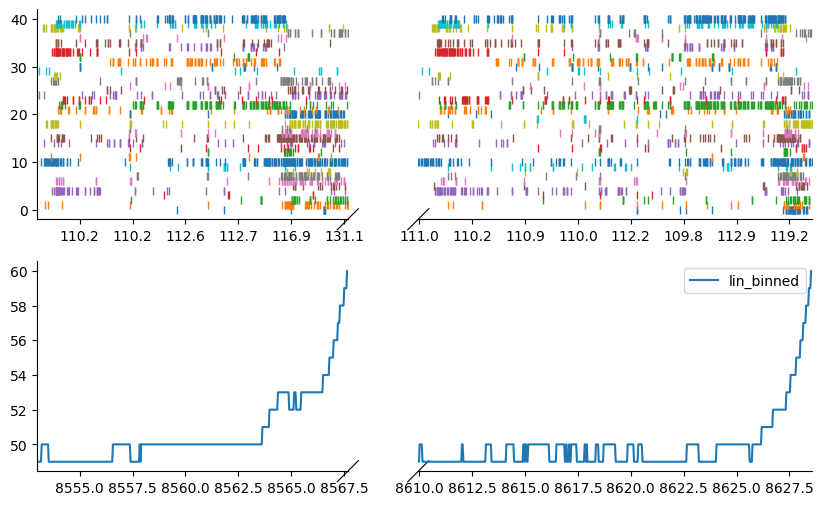

In [34]:
%matplotlib inline
reload(pr)
fig,axs=pr.population_raster_with_behvar(spike_trains,spk_beh_df,uid_l=uid_l,ep=ep,behvar_l=['lin_binned'],convert_to_pos='lin')
fig

In [35]:
df_d_epochs={k:[] for k in participation_mask_l_d_epochs[0].keys()}
for ii,(pmld,rtild) in enumerate(zip(participation_mask_l_d_epochs,ripple_time_ints_l_d_epochs)):
    df_d = {}
    for k,val in pmld.items():
        df_d[k] = pd.DataFrame(val,columns=cell_cols_d['pyr'].astype(int))
        df_d[k]['start'] = rtild[k][:,0]
        df_d[k]['end'] = rtild[k][:,1]
        df_d[k]['epoch'] = ii
        df_d_epochs[k].append(df_d[k])
df_d_epochs = {k:pd.concat(val,axis=0,ignore_index=True) for k,val in df_d_epochs.items()}
participation_df = df_d_epochs

In [316]:
mergepoints['timestamps']

array([[    0.        ,  7845.98396667],
       [ 7845.984     , 10023.71196667],
       [10023.712     , 16561.95196667]])

In [37]:
def select_ripples_by_ranking_participating_neurons_with_target_neuron(df,target,uid_l,nripples=3):
    ma=df.loc[:,target]
    sum_sorted = df.loc[ma,uid_l].sum(axis=1).sort_values(ascending=False)
    df_sorted=df.loc[sum_sorted.index,['start','end','epoch']]
    df_sorted['sum'] = sum_sorted.values
    df_sorted_sub = df_sorted.iloc[:nripples]
    return df_sorted,df_sorted_sub
    
    

In [346]:
participation_sorted,participation_sorted_sub=select_ripples_by_ranking_participating_neurons_with_target_neuron(participation_df['extended'],target=uid,uid_l=uid_l,nripples=3)
gpb=participation_sorted.groupby('epoch')
participation_sorted.groupby('epoch').head(3)

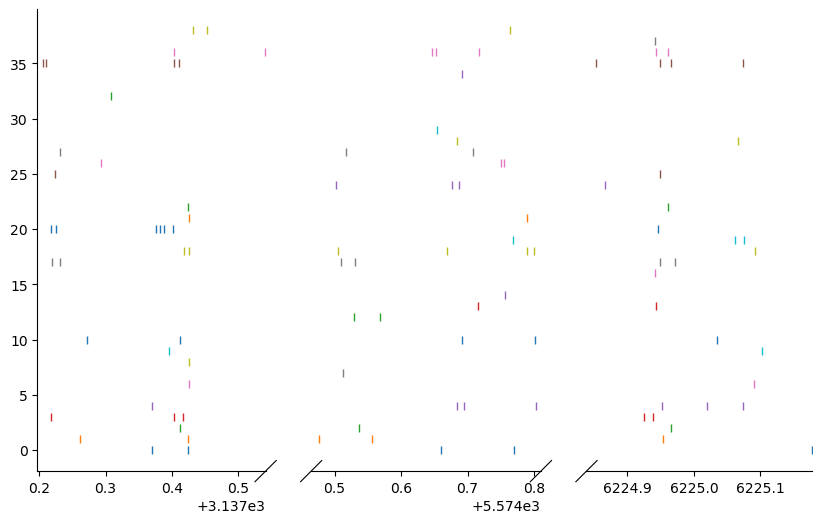

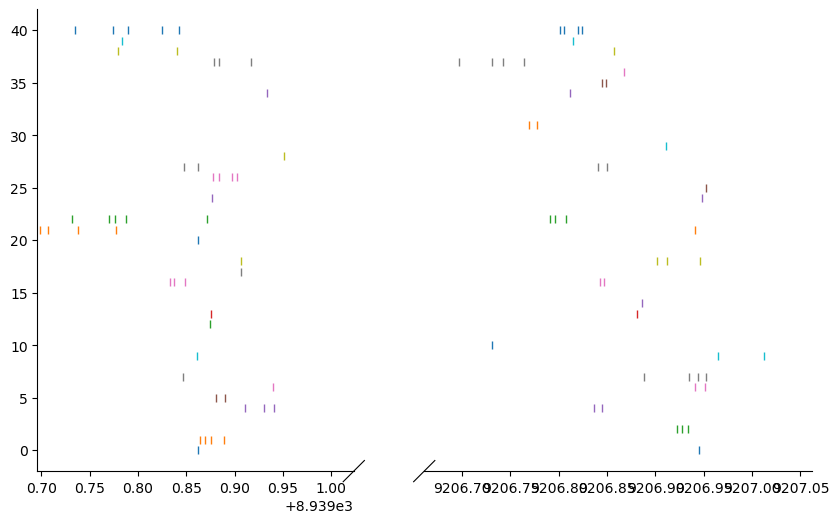

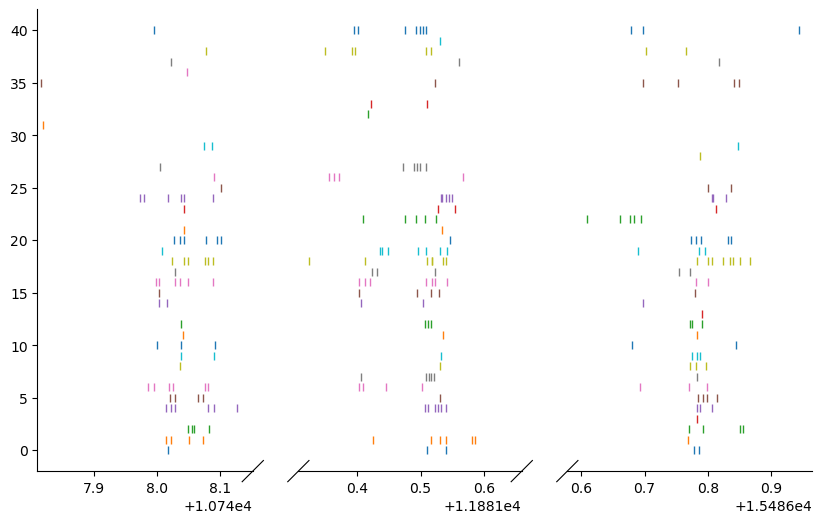

In [361]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

uid_l = list(selected_d.values())[0]
uid_l.insert(0,uid)
reload(pr)
# ep = (spk_beh_df.loc[ma].index[0],spk_beh_df.loc[ma].index[-1])
for k,val in gpb:
    ripple_ep_selected = val.head(3)[['start','end']].values
    fig,ax,_=pr.population_raster(spike_trains,uid_l=uid_l,ep=ripple_ep_selected,pos_func=None)


In [41]:
uid_l_from_preripple = sim_df_l[0].loc[uid].sort_values(ascending=False).iloc[:40].index

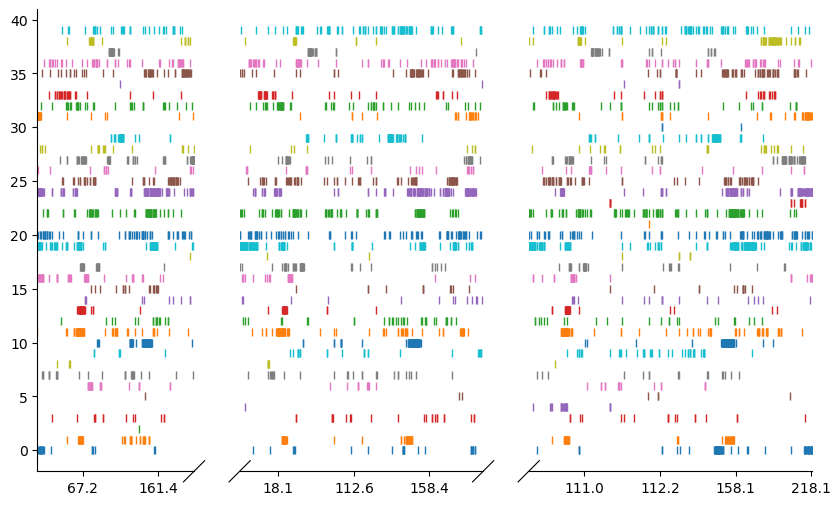

In [43]:
%matplotlib inline
# uid_l = list(selected_d.values())[0]
# uid_l.insert(0,uid)
reload(pr)
# ep = (spk_beh_df.loc[ma].index[0],spk_beh_df.loc[ma].index[-1])
ep=pf.get_trial_ep(spk_beh_df,trial_type=(0,1),pos_range=None,pos_key='lin',trial_index_range=None,trial_index_within_trialtype_range=(12,14))
fig,ax,_=pr.population_raster(spike_trains,uid_l=uid_l_from_preripple,ep=ep,pos_func=lin_func)
fig

In [79]:
uid_l_from_preripple

Int64Index([162, 291, 203,  38, 443, 158, 129, 207, 348,  82, 288, 216, 149,
            299, 154, 180, 196, 118, 435,  93,  35, 296,  52, 446,  37,  32,
            197, 155, 222, 104, 401, 113,  56, 157, 367, 114, 109, 357, 161,
             83],
           dtype='int64')

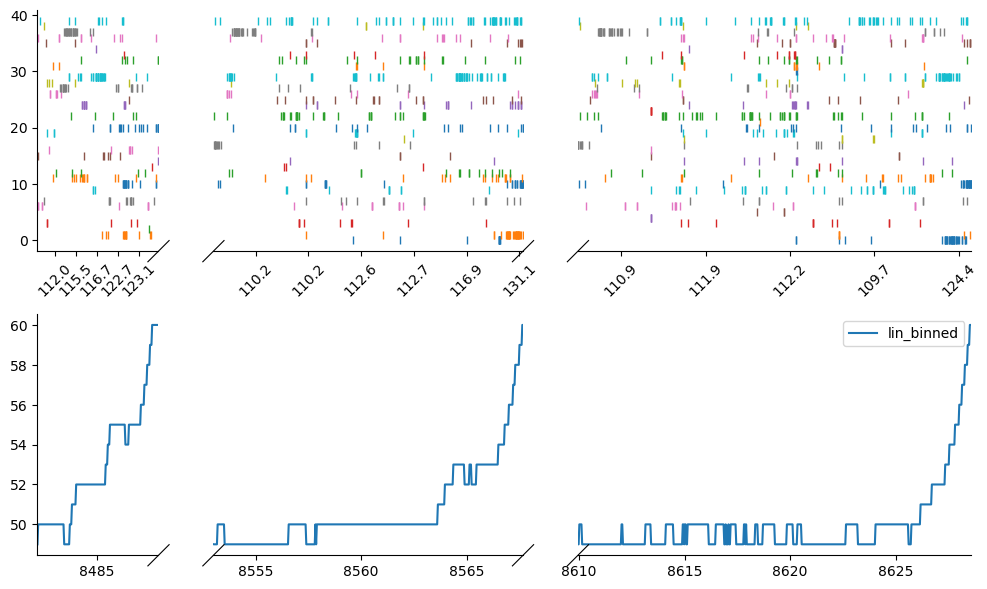

In [97]:
%matplotlib inline
reload(pr)
# ep=pf.get_trial_ep(spk_beh_df,trial_type=(0,1),pos_range=None,pos_key='lin',trial_index_range=None,trial_index_within_trialtype_range=(12,14)) # whole trials
ep=pf.get_trial_ep(spk_beh_df,trial_type=(0,1),pos_range=(110,135),pos_key='lin',trial_index_range=None,trial_index_within_trialtype_range=(12,14)) # only a part
fig,axs=pr.population_raster_with_behvar(spike_trains,spk_beh_df,uid_l=uid_l_from_preripple,ep=ep,behvar_l=['lin_binned'],convert_to_pos='lin')
fig

In [387]:
uid_l_from_preripple

Int64Index([162, 291, 203,  38, 443, 158, 129, 207, 348,  82, 288, 216, 149,
            299, 154, 180, 196, 118, 435,  93,  35, 296,  52, 446,  37,  32,
            197, 155, 222, 104, 401, 113,  56, 157, 367, 114, 109, 357, 161,
             83],
           dtype='int64')

In [392]:
sim_df_l[0][uid][]

1      0.026432
2      0.023529
3      0.023923
27     0.277523
29     0.245515
         ...   
476    0.044150
477    0.009780
478    0.046809
479    0.177264
480    0.105121
Name: 162, Length: 422, dtype: float64

In [389]:
fr_map_peaks_tested_df.loc[uid_l_from_preripple]

,0,1,2
162,56.0,NaN,NaN
291,20.0,62.0,NaN
203,NaN,NaN,NaN
38,43.0,NaN,NaN
443,15.0,NaN,NaN
158,NaN,NaN,NaN
129,32.0,NaN,NaN
207,59.0,NaN,NaN
348,NaN,NaN,NaN
82,19.0,NaN,NaN


In [372]:
participation_sorted

,start,end,epoch,sum
1623,6185.5304,6185.9032,0,39
1473,5772.4840,5772.8184,0,39
4450,16477.0120,16477.3512,2,39
4449,16476.9368,16477.2824,2,39
3933,14952.4360,14952.7904,2,39
...,...,...,...,...
3639,14106.6440,14106.9720,2,6
1546,6004.6584,6004.9872,0,6
2694,11752.2720,11752.6048,2,6
1194,4882.5104,4882.8304,0,5


In [38]:
uid

162

In [39]:
uid_l

Int64Index([162, 228, 148, 124, 111, 347, 206, 238, 466, 210,  27, 474, 306,
            181, 115, 247, 423, 359, 105, 342, 164, 201, 236, 205,  83, 227,
            207, 104, 369, 182, 172, 174,  31, 218, 409, 252, 160, 312, 235,
            273,  55],
           dtype='int64')

In [64]:
ripple_ep_selected

array([[16477.012 , 16477.3512],
       [16476.9368, 16477.2824],
       [14952.436 , 14952.7904]])

In [68]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [75]:
gpb.get_group(1).head(3)

,start,end,epoch,sum
1947,9612.9912,9613.3392,1,28
1948,9613.1256,9613.4800,1,27
1890,8530.9512,8531.2960,1,25


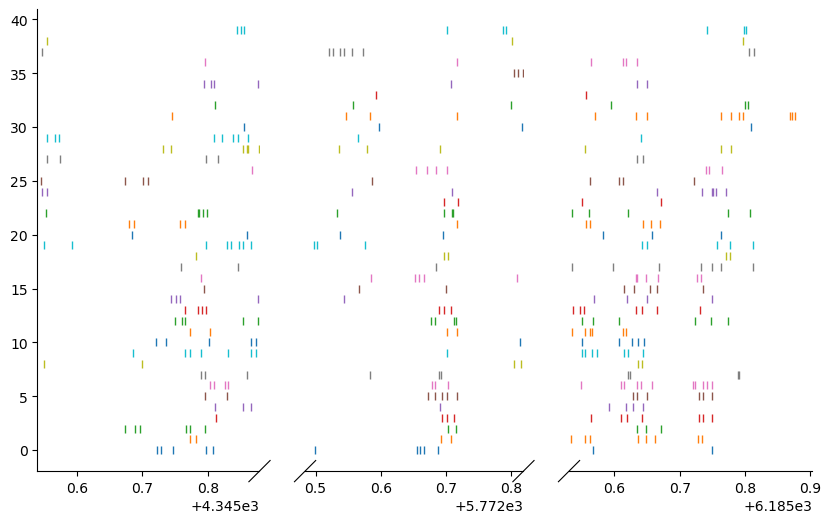

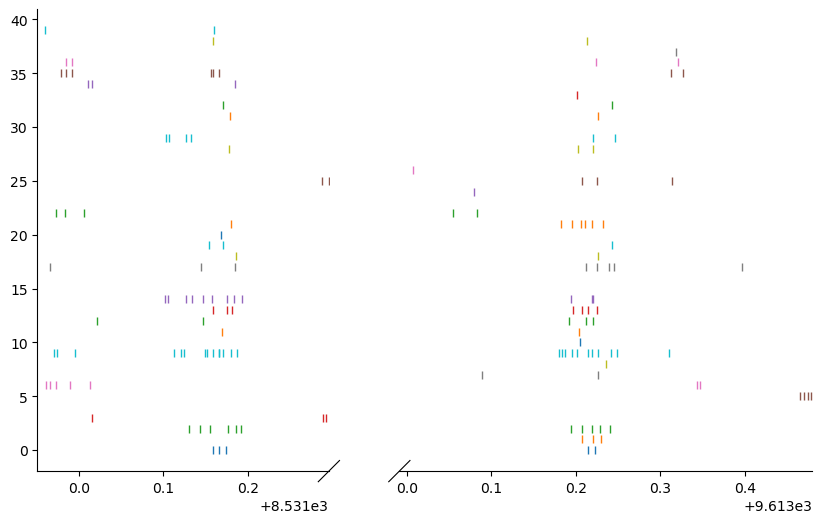

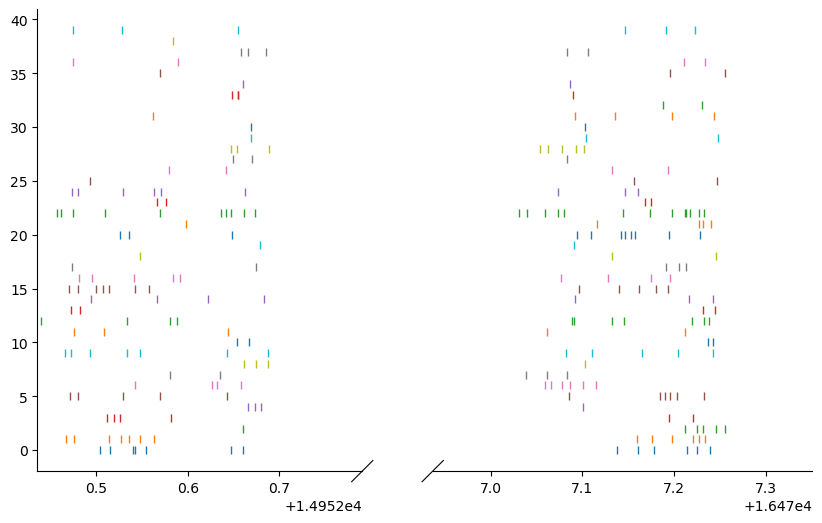

In [76]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

participation_sorted,participation_sorted_sub=select_ripples_by_ranking_participating_neurons_with_target_neuron(participation_df['extended'],target=uid,uid_l=uid_l_from_preripple,nripples=3)
gpb=participation_sorted.groupby('epoch')
# uid_l = list(selected_d.values())[0]
# uid_l.insert(0,uid)
reload(pr)
# ep = (spk_beh_df.loc[ma].index[0],spk_beh_df.loc[ma].index[-1])
for k,val in gpb:
    ripple_ep_selected = val.head(3)[['start','end']].values
    fig,ax,_=pr.population_raster(spike_trains,uid_l=uid_l_from_preripple,ep=ripple_ep_selected,pos_func=None)
    plt.show(fig)

    

In [397]:
sim_df_l[0][uid]

1      0.026432
2      0.023529
3      0.023923
27     0.277523
29     0.245515
         ...   
476    0.044150
477    0.009780
478    0.046809
479    0.177264
480    0.105121
Name: 162, Length: 422, dtype: float64

In [400]:
field_and_ripple_dist=pd.DataFrame([dist_sorted_d[56],sim_df_l[0][uid],sim_df_l[1][uid],sim_df_l[2][uid]],index=['peak_dist','ripple_sim_pre','ripple_sim_beh','ripple_sim_post']).T



In [402]:
field_and_ripple_dist.corr()

,peak_dist,ripple_sim_pre,ripple_sim_beh,ripple_sim_post
peak_dist,1.000000,-0.075653,-0.052916,-0.120381
ripple_sim_pre,-0.075653,1.000000,0.596501,0.892372
ripple_sim_beh,-0.052916,0.596501,1.000000,0.637923
ripple_sim_post,-0.120381,0.892372,0.637923,1.000000


In [405]:
ma=field_and_ripple_dist['peak_dist'].notna()

In [407]:
scipy.stats.pearsonr(field_and_ripple_dist['peak_dist'].loc[ma],field_and_ripple_dist['ripple_sim_pre'].loc[ma])

(-0.07565254865277478, 0.2380855987939524)

In [427]:
ripple_int_pre = nap.IntervalSet(start=participation_df['extended'].query('epoch==0')['start'].values,end=participation_df['extended'].query('epoch==0')['end'].values)

ripple_int_post = nap.IntervalSet(start=participation_df['extended'].query('epoch==2')['start'].values,end=participation_df['extended'].query('epoch==2')['end'].values)



In [422]:
spike_trains_pre_ripples = spike_trains.restrict(ripple_int_pre)

%time ccg_pre = nap.compute_crosscorrelogram(spike_trains_pre_ripples,binsize=0.001,windowsize=0.1,norm=False)

In [428]:
spike_trains_post_ripples = spike_trains.restrict(ripple_int_post)

%time ccg_post = nap.compute_crosscorrelogram(spike_trains_post_ripples,binsize=0.001,windowsize=0.1,norm=False)

CPU times: user 11min 6s, sys: 1.78 s, total: 11min 7s
Wall time: 11min 7s


In [425]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913'

In [426]:
ccg_pre.to_pickle(os.path.join(data_dir_full,'py_data','ccg_pre_ripple.p'))

In [429]:
ccg_post.to_pickle(os.path.join(data_dir_full,'py_data','ccg_post_ripple.p'))

In [433]:
uid_l_from_preripple

Int64Index([162, 291, 203,  38, 443, 158, 129, 207, 348,  82, 288, 216, 149,
            299, 154, 180, 196, 118, 435,  93,  35, 296,  52, 446,  37,  32,
            197, 155, 222, 104, 401, 113,  56, 157, 367, 114, 109, 357, 161,
             83],
           dtype='int64')

In [438]:
def get_ccg_cols(target_uid,uid_l):
    cols = []
    for u in uid_l:
        if target_uid > u:
            cols.append((u,target_uid))
        elif target_uid<u:
            cols.append((target_uid,u))
    return cols

In [472]:
dist_sorted_d

{56.0: 162    0.0
 228    0.0
 148    1.0
 124    1.0
 111    1.0
       ... 
 472    NaN
 473    NaN
 477    NaN
 478    NaN
 479    NaN
 Length: 422, dtype: float64}

In [480]:
uid_sorted_by_dist = list(dist_sorted_d.values())[0].index
cols = get_ccg_cols(uid,uid_sorted_by_dist)

In [447]:
fr_map_peaks_tested_df

,0,1,2
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,31.0,NaN,NaN
27,55.0,NaN,NaN
29,30.0,61.0,NaN
...,...,...,...
476,32.0,NaN,NaN
477,NaN,NaN,NaN
478,NaN,NaN,NaN
479,NaN,NaN,NaN


In [455]:
fr_map_peaks_tested_df

,0,1,2
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,31.0,NaN,NaN
27,55.0,NaN,NaN
29,30.0,61.0,NaN
...,...,...,...
476,32.0,NaN,NaN
477,NaN,NaN,NaN
478,NaN,NaN,NaN
479,NaN,NaN,NaN


In [494]:
def plot_ccg_one_col(ccg,col,fig=None,ax=None,title=''):
    
    toplot_v=ccg.loc[:,col].values
    if col[0] < col[1]:
        toplot_v = np.flip(toplot_v)
    if ax is None:
        fig,ax=plt.subplots()
    ax.plot(ccg.index,toplot_v)
    ax.set_title(title)
    return fig,ax
        
    

In [534]:
np.nonzero(uid_sorted_by_dist==279)[0][0]

91

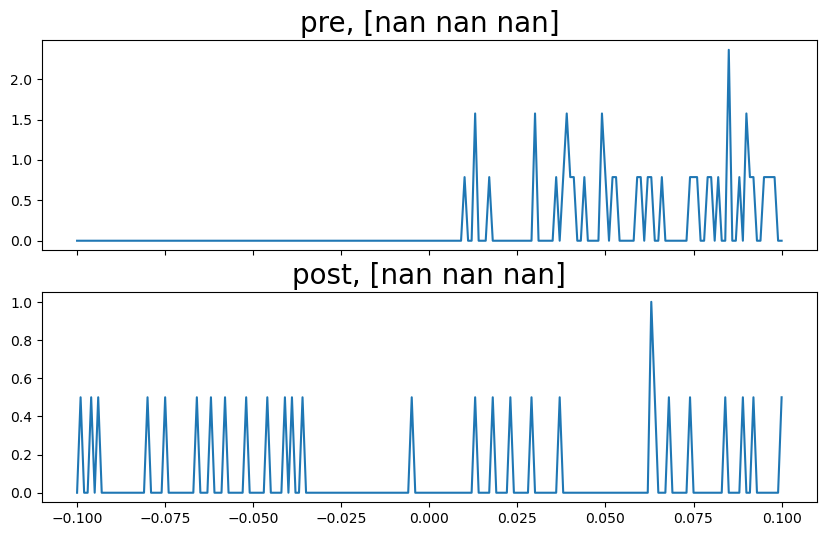

In [547]:
ind=np.nonzero(uid_sorted_by_dist==282)[0][0]#400
fig,axs=plt.subplots(2,1,sharex=True,figsize=(10,6))
toplot=ccg_pre.loc[:,cols].iloc[:,ind]
# ax=toplot.plot(ax=axs[0])
# ax.set_title()
title = f'pre, {fr_map_peaks_tested_df.loc[uid_sorted_by_dist[ind]].values}'
fig,ax=plot_ccg_one_col(ccg_pre,cols[ind],fig,ax=axs[0],title=title)

# toplot=ccg_post.loc[:,cols].iloc[:,ind]
title = f'post, {fr_map_peaks_tested_df.loc[uid_sorted_by_dist[ind]].values}'
fig,ax=plot_ccg_one_col(ccg_post,cols[ind],fig,ax=axs[1],title=title)

# ax=toplot.plot(ax=axs[1])
# ax.set_title(f'post, {fr_map_peaks_tested_df.loc[uid_sorted_by_dist[ind]].values}')


In [528]:
sim_change_pre_post_one = (sim_df_l[0].loc[uid] - sim_df_l[-1].loc[uid]).abs().sort_values(ascending=False)

In [538]:
sim_df_l[0].loc[uid,279]

0.21725239616613423

In [539]:
sim_df_l[-1].loc[uid,279]

0.4275303643724696

In [543]:
sim_change_pre_post_one = pd.DataFrame([sim_change_pre_post_one,sim_df_l[0].loc[uid], sim_df_l[-1].loc[uid]],index=['change','pre','post']).T

In [544]:
sim_change_pre_post_one

,change,pre,post
279,0.210278,0.217252,0.427530
339,0.196906,0.170472,0.367378
446,0.188005,0.333333,0.145329
124,0.184759,0.134518,0.319277
369,0.174425,0.150250,0.324675
...,...,...,...
282,0.000795,0.203438,0.202643
264,0.000000,0.000000,0.000000
289,0.000000,0.000000,0.000000
302,0.000000,0.000000,0.000000


Text(0.5, 1.0, '[52. nan nan]')

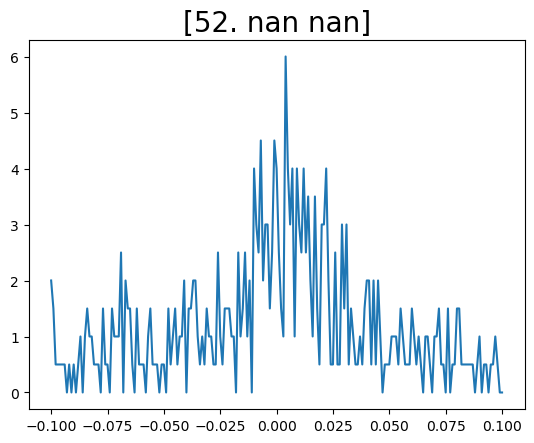

In [486]:
# ind=55
toplot=ccg_post.loc[:,cols].iloc[:,ind]
ax=toplot.plot()
ax.set_title(fr_map_peaks_tested_df.loc[uid_sorted_by_dist[ind]].values)
